# Определение перспективного тарифа для телеком компании

## Вводная информация

Описание тарифов
Тариф «Смарт»
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
 *	минута разговора: 3 рубля
 *	сообщение: 3 рубля
 *	1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
 *	минута разговора: 1 рубль
 *	сообщение: 1 рубль
 *	1 Гб интернет-трафика: 150 рублей
Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.


Цель - на оснвовании проверки двух гипотез определить тариф, который приносит большую выручку:
 *	средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
 *  средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

## Изучение данных и предобработка

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import six
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Звонки

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
calls.query('duration==0')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
5,1000_5,2018-11-02,0.0,1000
6,1000_6,2018-10-18,0.0,1000
9,1000_9,2018-08-15,0.0,1000
...,...,...,...,...
202590,1499_203,2018-12-03,0.0,1499
202592,1499_205,2018-10-13,0.0,1499
202593,1499_206,2018-12-26,0.0,1499
202594,1499_207,2018-10-28,0.0,1499


In [6]:
calls.duplicated().sum()

0

В файле с информацией по звонкам около 20% занимают звонки с длительностью 0 секунд. Предположительно это пропущенные звонки и они не нужны нам для рассчётов. С другой стороны есть вероятность, что большая доля пропущенных звонков вынуждает пользователей больше отправлять сообщения или пользоваться интернетом. Пока что оставим их.

Поле с датой звонка приведём к соответствующему типу, длительность звонков округлим вверх до целого согласно тарификации компании.

Повторов записей нет благодаря уникальному id для каждого звонка.

In [7]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = np.ceil(calls['duration'])

In [8]:
def missed_calls_ind(series):
    if series['duration'] == 0:
        return True
    else:
        return False

calls['missed'] = calls.apply(missed_calls_ind, axis=1)

Я добавил поле с информацией о том, считается ли звонок пропущенным (пропущенный обозначил как True), чтобы потом понять долю этих звонков для конкретных пользователей.

### Интернет

In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [10]:
internet.tail()

,Unnamed: 0,id,mb_used,session_date,user_id
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


In [11]:
internet.duplicated().sum()

0

В файле с информацией об использовании интерента пользователями нет дублей и пропущенных значений. Есть столбец дублирующий индексы, от него мы избавимся.
Дату приведём к соответствующему типу.
Также округлим кол-во мегабайт до целых чисел.

In [12]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['mb_used'] = np.ceil(internet['mb_used'])
internet.drop(columns=['Unnamed: 0'], inplace=True)

### Сообщения

In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [14]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [15]:
messages.duplicated().value_counts()

False    123036
dtype: int64

В файле с информацией по отправленным сообщениям нет пропусков или дублей.
Приведём только дату к нужному типу.

In [16]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

### Пользователи

In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [18]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


В файле по пользователям есть пропуски в поле с датой прекращения использования тарифа - это пользователи, которые ещё продолжают им пользоваться. Заполнять их смысла нет, но есть смысл разметить на активных и прекративших сотрудничество пользователей. Также есть смысла проверить есть ли в файле дубли (по имя+фамилия+город+возраст).
Даты нужно привести к соответствующему типу, также список городов и тариф приведём к типу category.
Для имени и фамилии сделаем один столбец, чтобы иметь относительно уникальное поле для пользователя.
Также индексы в этом датафрэйме можно заменить значением user_id для того, чтобы в дальнейшем было удобнее объединять таблицы.

In [19]:
def user_quit(series):
    if pd.isna(series['churn_date']):
        return True
    else:
        return False

users['active'] = users.apply(user_quit, axis=1)

In [20]:
users['full_name'] = users['first_name'] + ' ' + users['last_name']

In [21]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['city'] = users['city'].astype('category')
users['tariff'] = users['tariff'].astype('category')

In [22]:
users.set_index('user_id', inplace=True)

In [23]:
users.head()

,age,churn_date,city,first_name,last_name,reg_date,tariff,active,full_name
user_id,,,,,,,,,
1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,True,Рафаил Верещагин
1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,True,Иван Ежов
1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,True,Евгений Абрамович
1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,True,Белла Белякова
1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,True,Татьяна Авдеенко


In [24]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 9 columns):
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null category
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null category
active        500 non-null bool
full_name     500 non-null object
dtypes: bool(1), category(2), datetime64[ns](2), int64(1), object(3)
memory usage: 32.0+ KB


### Тарифы

In [25]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [26]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [27]:
tariffs.set_index('tariff_name', inplace=True)

С информацией о тарифах всё в порядке, она соответствует заявленной в условиях проекта.
Я заменю индексы на названия тарифов, чтобы мне было проще к ним обращаться в дальнейшем.

## Подготовка данных

Посчитайте для каждого пользователя:
*	количество сделанных звонков и израсходованных минут разговора по месяцам;
*	количество отправленных сообщений по месяцам;
*	объем израсходованного интернет-трафика по месяцам;
*	помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).


In [28]:
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

In [29]:
calls_by_user = calls.query('missed == False').pivot_table(index=['user_id', 'month'], values=['duration'], aggfunc=('count', 'sum'))
calls_by_user.columns = ['number_of_calls', 'calls_duration']

In [30]:
calls_by_user = calls_by_user.reset_index()
calls_by_user['user_id'].nunique()

492

Я собрал информацию помесячно по разговорам всех пользователей за год.
Также я сделал id пользователя и месяц звонка отдельными столбцами, чтобы мне было проще работать с ними при объединении.

In [31]:
messages['month'] = messages['message_date'].values.astype('datetime64[M]')

In [32]:
messages_by_user = messages.pivot_table(index=['user_id', 'month'], values=['id'], aggfunc=('count'))
messages_by_user.columns = ['number_of_messages']
messages_by_user = messages_by_user.reset_index()
messages_by_user['user_id'].nunique()


426

In [33]:
internet['month'] = internet['session_date'].values.astype('datetime64[M]')

In [34]:
mb_by_user = internet.pivot_table(index=['user_id', 'month'], values=['mb_used'], aggfunc=('sum'))
mb_by_user.columns = ['traffic']
mb_by_user = mb_by_user.reset_index()
mb_by_user['user_id'].nunique()

497

In [35]:
common_data = calls_by_user.merge(mb_by_user, on=['user_id', 'month'], how='outer', left_index=True)
common_data = common_data.merge(messages_by_user, on=['user_id', 'month'], how='outer', left_index=True)

In [36]:
common_data['user_id'].nunique()

498

In [37]:
common_data.reset_index(drop=True, inplace=True)
common_data[['number_of_calls','calls_duration', 'traffic', 'number_of_messages']] = common_data[['number_of_calls','calls_duration', 'traffic', 'number_of_messages']].fillna(value=0)

Я собрал данные помесячно по всем пользователям. Обнаружилось, что 2 клиента вообще не воспользовались услугами, некоторые из клиентов не использовали конкретные услуги. Т.к. мы оцениваем насколько выгодны и удобны тарифы для пользователей - эти два клиента нам не нужны, т.к. они вообще не воспользовались услугами за всё время работы.
Далее нам необходимо рассчитать стоимость услуг сверх тарифа, а также расходы на абонентскую плату. Её я буду считать за все месяцы с момента регистрации, т.к. иного значения нам не дано.

In [38]:
users['reg_month'] = users['reg_date'].values.astype('datetime64[M]')


In [39]:
def month_active(series):
    if series['churn_date'].month > 0:
        c = series['churn_date'].month - series['reg_month'].month + 1
    else:
        c = 13 - series['reg_month'].month
    fee = tariffs.loc[series['tariff']]['rub_monthly_fee']
    return pd.Series({'month_active':c, 'monthly_fee':fee})
    
users[['month_active','monthly_fee']] = users.apply(month_active, axis=1)
users

,age,churn_date,city,first_name,last_name,reg_date,tariff,active,full_name,reg_month,month_active,monthly_fee
user_id,,,,,,,,,,,,
1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,True,Рафаил Верещагин,2018-05-01,8,1950
1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,True,Иван Ежов,2018-11-01,2,550
1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,True,Евгений Абрамович,2018-06-01,7,550
1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,True,Белла Белякова,2018-08-01,5,1950
1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,True,Татьяна Авдеенко,2018-05-01,8,1950
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,True,Авксентий Фокин,2018-08-01,5,1950
1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,True,Трифон Блохин,2018-01-01,12,550
1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,True,Каролина Агеева,2018-10-01,3,550


При подсчёте абонентской платы я исходил из того, что она взымается каждый календарный месяц, а не за период в 30 дней. 

Посчитаем платежи за переплаты в каждом месяце за услуги использованные сверх пакетов. Для этого предварительно добавим в нашу таблицу значения тарифа для пользователя.

In [40]:
common_data.head(15)

,user_id,month,number_of_calls,calls_duration,traffic,number_of_messages
0,1000,2018-05-01,17.0,159.0,2256.0,22.0
1,1000,2018-06-01,28.0,172.0,23257.0,60.0
2,1000,2018-07-01,41.0,340.0,14016.0,75.0
3,1000,2018-08-01,42.0,408.0,14070.0,81.0
4,1000,2018-09-01,46.0,466.0,14581.0,57.0
5,1000,2018-10-01,44.0,350.0,14717.0,73.0
6,1000,2018-11-01,37.0,338.0,14768.0,58.0
7,1000,2018-12-01,38.0,333.0,9827.0,70.0
8,1001,2018-11-01,45.0,430.0,18452.0,0.0
9,1001,2018-12-01,47.0,414.0,14053.0,0.0


In [41]:
common_data = common_data.join(users[['tariff', 'city','monthly_fee' ]], how='left', on='user_id')

In [42]:
def revenue_counter(series):
    prices = tariffs.loc[series['tariff']][['minutes_included','rub_per_minute','messages_included','rub_per_message', 'mb_per_month_included','rub_per_gb']]
    calls_rev = (series['calls_duration'] - prices['minutes_included'])*prices['rub_per_minute']
    if calls_rev < 0:
        calls_rev = 0
    int_rev = ((series['traffic'] - prices['mb_per_month_included'])/1024*prices['rub_per_gb']).round(2)
    if int_rev < 0:
        int_rev = 0
    msg_rev = (series['number_of_messages'] - prices['messages_included'])*prices['rub_per_message']
    if msg_rev < 0:
        msg_rev = 0
    total = calls_rev + int_rev + msg_rev+series['monthly_fee']
    return pd.Series({"calls_revenue": calls_rev, "int_revenue": int_rev, 'msg_revenue': msg_rev, 'total_revenue': total})

common_data[['calls_revenue', 'int_revenue', 'msg_revenue', 'total_revenue']] = common_data.apply(revenue_counter, axis=1)

In [43]:
common_data.head(40)

,user_id,month,number_of_calls,calls_duration,traffic,number_of_messages,tariff,city,monthly_fee,calls_revenue,int_revenue,msg_revenue,total_revenue
0,1000,2018-05-01,17.0,159.0,2256.0,22.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00
1,1000,2018-06-01,28.0,172.0,23257.0,60.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00
2,1000,2018-07-01,41.0,340.0,14016.0,75.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00
3,1000,2018-08-01,42.0,408.0,14070.0,81.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00
4,1000,2018-09-01,46.0,466.0,14581.0,57.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00
5,1000,2018-10-01,44.0,350.0,14717.0,73.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00
6,1000,2018-11-01,37.0,338.0,14768.0,58.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00
7,1000,2018-12-01,38.0,333.0,9827.0,70.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00
8,1001,2018-11-01,45.0,430.0,18452.0,0.0,smart,Москва,550,0.0,603.91,0.0,1153.91
9,1001,2018-12-01,47.0,414.0,14053.0,0.0,smart,Москва,550,0.0,0.00,0.0,550.00


Сделаем отдельную таблицу с общими расходами на пользователя

In [44]:
user_stats = common_data.pivot_table(index='user_id', values=['calls_revenue', 'int_revenue', 'msg_revenue', 'total_revenue','number_of_calls','calls_duration', 'traffic', 'number_of_messages'], aggfunc='sum')
user_stats = user_stats.merge(users, how='left', left_on=user_stats.index, right_on=users.index, left_index=True)
user_stats.drop(columns='key_0', inplace=True)

In [45]:
user_stats.head()


,calls_duration,calls_revenue,int_revenue,msg_revenue,number_of_calls,number_of_messages,total_revenue,traffic,age,churn_date,city,first_name,last_name,reg_date,tariff,active,full_name,reg_month,month_active,monthly_fee
user_id,,,,,,,,,,,,,,,,,,,,
1000,2566.0,0.0,0.00,0.0,293.0,496.0,15600.00,107492.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,True,Рафаил Верещагин,2018-05-01,8,1950
1001,844.0,0.0,603.91,0.0,92.0,0.0,1703.91,32505.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,True,Иван Ежов,2018-11-01,2,550
1002,1517.0,0.0,2852.93,0.0,173.0,70.0,6702.93,116183.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,True,Евгений Абрамович,2018-06-01,7,550
1003,3822.0,0.0,0.00,0.0,428.0,380.0,9750.00,57329.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,True,Белла Белякова,2018-08-01,5,1950
1004,987.0,0.0,0.00,0.0,139.0,1192.0,15600.00,149172.0,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,True,Татьяна Авдеенко,2018-05-01,8,1950


### Вывод

Итого у меня есть две таблицы с собранными данными для дальнейшей работы - user_stats и с данными расписанными по месяцам, если мне будет необходимо проработать с данными во времени.

## Исследовательский анализ данных

### Первичная оценка данных

Анализ сводных данных в таблице user_stats в текущем состоянии нам подойдёт не совсем. Поэтому посчитаем средние значения для пользователя в месяц, а не сумму за все месяцы.

In [46]:
user_stats.head()


,calls_duration,calls_revenue,int_revenue,msg_revenue,number_of_calls,number_of_messages,total_revenue,traffic,age,churn_date,city,first_name,last_name,reg_date,tariff,active,full_name,reg_month,month_active,monthly_fee
user_id,,,,,,,,,,,,,,,,,,,,
1000,2566.0,0.0,0.00,0.0,293.0,496.0,15600.00,107492.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,True,Рафаил Верещагин,2018-05-01,8,1950
1001,844.0,0.0,603.91,0.0,92.0,0.0,1703.91,32505.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,True,Иван Ежов,2018-11-01,2,550
1002,1517.0,0.0,2852.93,0.0,173.0,70.0,6702.93,116183.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,True,Евгений Абрамович,2018-06-01,7,550
1003,3822.0,0.0,0.00,0.0,428.0,380.0,9750.00,57329.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,True,Белла Белякова,2018-08-01,5,1950
1004,987.0,0.0,0.00,0.0,139.0,1192.0,15600.00,149172.0,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,True,Татьяна Авдеенко,2018-05-01,8,1950


In [47]:
user_stats['calls_duration_avg'] = user_stats['calls_duration']/user_stats['month_active']
user_stats['calls_revenue_avg'] = user_stats['calls_revenue']/user_stats['month_active']
user_stats['traffic_avg'] = user_stats['traffic']/user_stats['month_active']
user_stats['int_revenue_avg'] = user_stats['int_revenue']/user_stats['month_active']
user_stats['number_of_messages_avg'] = user_stats['number_of_messages']/user_stats['month_active']
user_stats['msg_revenue_avg'] = user_stats['msg_revenue']/user_stats['month_active']
user_stats['mean_revenue'] = user_stats['total_revenue']/user_stats['month_active']

user_stats.head()


,calls_duration,calls_revenue,int_revenue,msg_revenue,number_of_calls,number_of_messages,total_revenue,traffic,age,churn_date,...,reg_month,month_active,monthly_fee,calls_duration_avg,calls_revenue_avg,traffic_avg,int_revenue_avg,number_of_messages_avg,msg_revenue_avg,mean_revenue
user_id,,,,,,,,,,,,,,,,,,,,,
1000,2566.0,0.0,0.00,0.0,293.0,496.0,15600.00,107492.0,52,NaT,...,2018-05-01,8,1950,320.750000,0.0,13436.500000,0.000000,62.0,0.0,1950.000000
1001,844.0,0.0,603.91,0.0,92.0,0.0,1703.91,32505.0,41,NaT,...,2018-11-01,2,550,422.000000,0.0,16252.500000,301.955000,0.0,0.0,851.955000
1002,1517.0,0.0,2852.93,0.0,173.0,70.0,6702.93,116183.0,59,NaT,...,2018-06-01,7,550,216.714286,0.0,16597.571429,407.561429,10.0,0.0,957.561429
1003,3822.0,0.0,0.00,0.0,428.0,380.0,9750.00,57329.0,23,NaT,...,2018-08-01,5,1950,764.400000,0.0,11465.800000,0.000000,76.0,0.0,1950.000000
1004,987.0,0.0,0.00,0.0,139.0,1192.0,15600.00,149172.0,68,NaT,...,2018-05-01,8,1950,123.375000,0.0,18646.500000,0.000000,149.0,0.0,1950.000000


In [48]:
common_data.pivot_table(index='tariff', values=['calls_revenue','msg_revenue','int_revenue', 'monthly_fee'], aggfunc=['count','sum'], margins=True)

count                                               sum  \
       calls_revenue int_revenue monthly_fee msg_revenue calls_revenue   
tariff                                                                   
smart           2229        2229        2229        2229      278217.0   
ultra            985         985         985         985           0.0   
All             3214        3214        3214        3214      278217.0   

                                            
       int_revenue monthly_fee msg_revenue  
tariff                                      
smart   1206184.84     1225950     38784.0  
ultra    108872.05     1920750         0.0  
All     1315056.89     3146700     38784.0

За счёт разницы в размерах групп общие цифры не дают нам наглядную картину, поэтому посмотрим на средние значения.

In [49]:
common_data.pivot_table(index='tariff', values=['calls_revenue', 'calls_duration','msg_revenue','number_of_messages','int_revenue', 'traffic','monthly_fee', 'total_revenue'])

,calls_duration,calls_revenue,int_revenue,monthly_fee,msg_revenue,number_of_messages,total_revenue,traffic
tariff,,,,,,,,
smart,417.934948,124.816958,541.132723,550,17.399731,33.384029,1233.349412,16229.188425
ultra,526.623350,0.000000,110.530000,1950,0.000000,49.363452,2060.530000,19486.901523


Исходя из таблицы выше мы можем сделать следующие выводы:
 - в среднем на тарифе Смарт платят меньше почти вполовину
 - пользователи тарифа Смарт звонят меньше, но при этом доплачивают за звонки (на тарифе Ультра в этом нет нужды)
 - за интернет доплачивают пользователи обоих тарифов. При этом на Смарте тратят меньше трафика, но доплачивают больше чем на Ультра
 - сообщений на Ультре отправляют тоже больше, но вот доплачивать за это количество не приходится
 - в среднем пользователи тарифа Смарт тратят на 20-40% услуг меньше, но и платят на 35% меньше

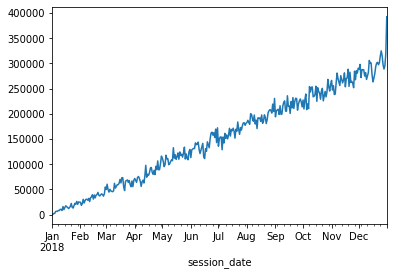

In [50]:
internet.groupby('session_date')['mb_used'].sum().plot()

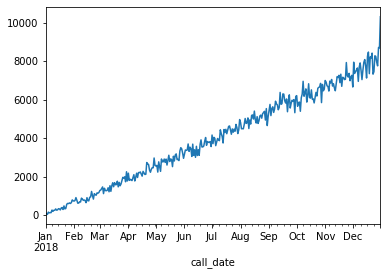

In [51]:
calls.groupby('call_date')['duration'].sum().plot()

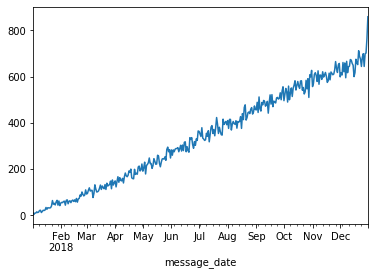

In [52]:
messages.groupby('message_date')['user_id'].count().plot()

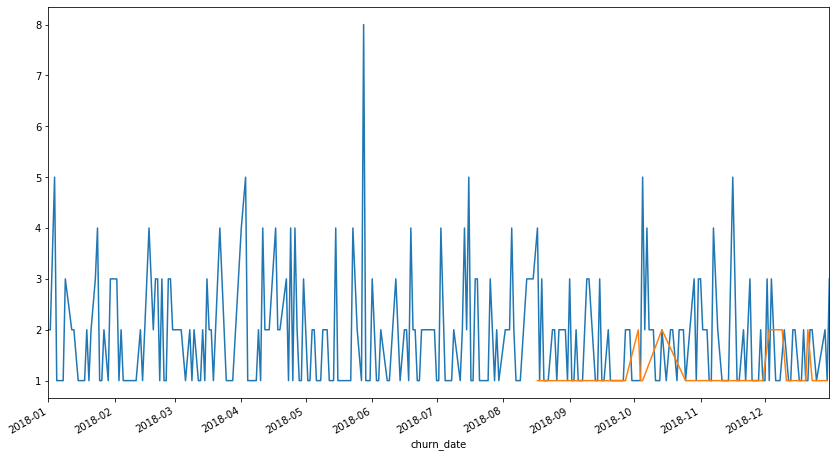

In [53]:
users.groupby('reg_date')['full_name'].count().plot(figsize=(14,8))
users.groupby('churn_date')['full_name'].count().plot()

Количество абонентов и объём используемых ими услуг равномерно рос в течение года.

In [54]:
common_data.head()

,user_id,month,number_of_calls,calls_duration,traffic,number_of_messages,tariff,city,monthly_fee,calls_revenue,int_revenue,msg_revenue,total_revenue
0,1000,2018-05-01,17.0,159.0,2256.0,22.0,ultra,Краснодар,1950,0.0,0.0,0.0,1950.0
1,1000,2018-06-01,28.0,172.0,23257.0,60.0,ultra,Краснодар,1950,0.0,0.0,0.0,1950.0
2,1000,2018-07-01,41.0,340.0,14016.0,75.0,ultra,Краснодар,1950,0.0,0.0,0.0,1950.0
3,1000,2018-08-01,42.0,408.0,14070.0,81.0,ultra,Краснодар,1950,0.0,0.0,0.0,1950.0
4,1000,2018-09-01,46.0,466.0,14581.0,57.0,ultra,Краснодар,1950,0.0,0.0,0.0,1950.0


In [94]:
common_data['month_num'] = common_data['month'].dt.month

In [100]:
np.arange(
    common_data['month'].dt.month.min(), common_data['month'].dt.month.max())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [97]:
common_data.query('tariff == "ultra"').groupby('month_num')['traffic'].mean()

month_num
1     13153.555556
2     11786.958333
3     17551.972973
4     16843.800000
5     19381.194030
6     18942.238095
7     20514.648352
8     19594.065421
9     19222.208696
10    20063.869919
11    19805.313433
12    21813.589928
Name: traffic, dtype: float64

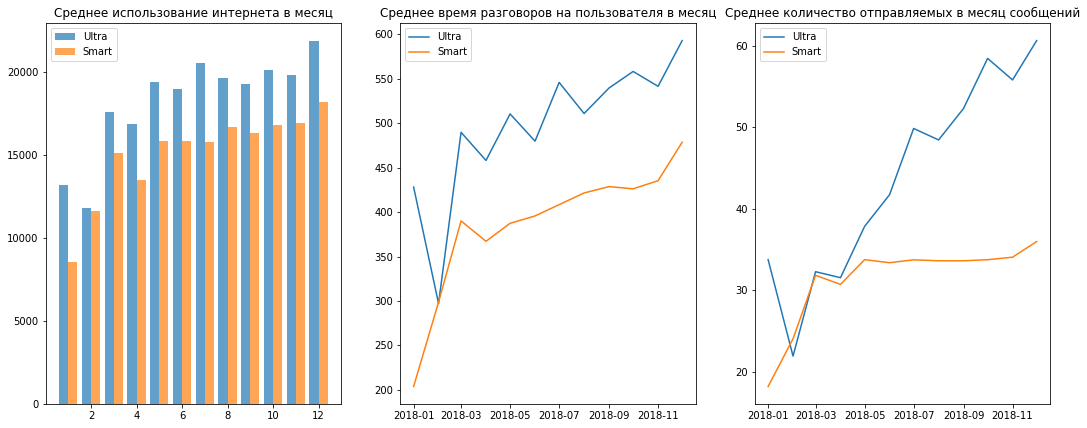

In [106]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,7))

ax1.bar(np.arange(
    common_data['month'].dt.month.min(), common_data['month'].dt.month.max()+1)-0.2,
        common_data.query('tariff == "ultra"').groupby('month_num')['traffic'].mean(), 
        label='Ultra', 
        width=0.4, 
        alpha=0.7, 
    )
ax1.bar(np.arange(
    common_data['month'].dt.month.min(),common_data['month'].dt.month.max()+1)+0.2,
        common_data.query('tariff == "smart"').groupby('month_num')['traffic'].mean(), 
        label='Smart',  
        width=0.4, 
        alpha=0.7, 
    )
#ax1.plot(common_data.query('tariff == "ultra"').groupby('month')['traffic'].mean(), label='Ultra')
#ax1.plot(common_data.query('tariff == "smart"').groupby('month')['traffic'].mean(), label='Smart')
ax2.plot(common_data.query('tariff == "ultra"').groupby('month')['calls_duration'].mean(), label='Ultra')
ax2.plot(common_data.query('tariff == "smart"').groupby('month')['calls_duration'].mean(), label='Smart')
ax3.plot(common_data.query('tariff == "ultra"').groupby('month')['number_of_messages'].mean(), label='Ultra')
ax3.plot(common_data.query('tariff == "smart"').groupby('month')['number_of_messages'].mean(), label='Smart')
ax1.title.set_text('Среднее использование интернета в месяц')
ax2.title.set_text('Среднее время разговоров на пользователя в месяц')
ax3.title.set_text('Среднее количество отправляемых в месяц сообщений')
ax3.legend()
ax2.legend()
ax1.legend()
plt.show()

Из графиков мы наглядно видим, что в течение года среднее использование услуг на пользователя росло. При этом:
 - использование интернето имело быстрый рост в начале года и продолжало расти с большим потреблением пользователями тарифа Ультра
 - использование телефонной связи росло похожим образом
 - среднее количество отправляемых сообщений для пользователей тарифа Смарт к маю достигло некоторой отметки и оставалось примерно там, пользователи тарифа Ультра продолжали увеличивать количество отправляемых сообщений.

### Звонки

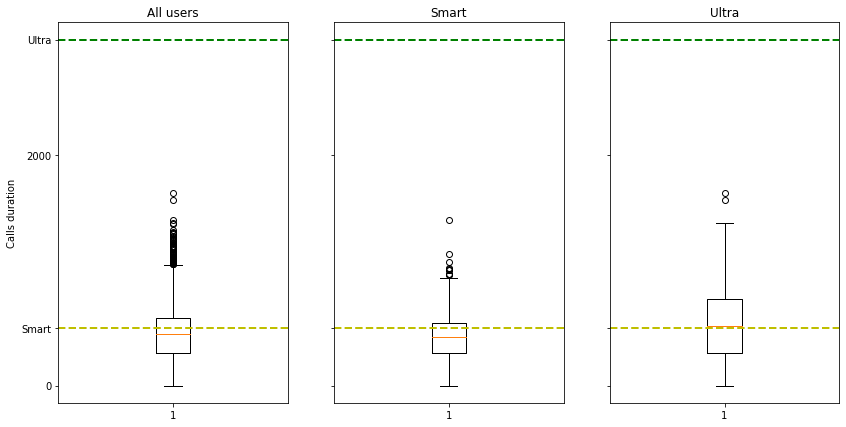

In [57]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(14,7))
ax1.boxplot(common_data['calls_duration'])
ax2.boxplot(common_data.query('tariff == "smart"')['calls_duration'])
ax3.boxplot(common_data.query('tariff == "ultra"')['calls_duration'])


ax1.title.set_text('All users')
ax2.title.set_text('Smart')
ax3.title.set_text('Ultra')

ax1.set_ylabel('Calls duration')
ax1.set_yticks([0,500,2000,3000,6000,8000,10000,12000])
ax1.set_yticklabels([0, 'Smart', 2000, 'Ultra',3000,6000,8000,10000,12000])

for axe in f.axes:
    axe.axhline(y=500,
                linewidth=2, 
                color='y', 
                linestyle='--')
    axe.axhline(y=3000,
                linewidth=2, 
                color='g', 
                linestyle='--')



plt.show()

На графиках выше можно наглядно увидеть, что пользователям тарифа Ультра можно общаться ещё больше и доплачивать не придётся. На тарифе Смарт в предоставленный объём звонков умещается около 75% пользователей. Возможно они при наличии такой статистики задумались бы о переходе на тариф повыше.
Также после оценки других факторов возможно есть смысл снизить количество минут в рамках тарифа и перераспределить оставшийся лимит на интернет либо вовсе снизить абонентскую плату.


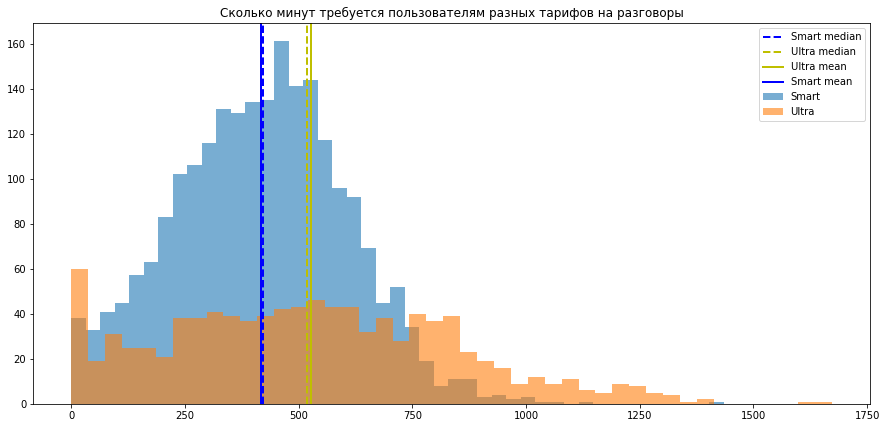

In [58]:
plt.figure(figsize=(15,7))
plt.hist(common_data.query('tariff == "smart"')['calls_duration'], alpha=0.6, label='Smart', bins=45)
plt.hist(common_data.query('tariff == "ultra"')['calls_duration'], alpha=0.6, label='Ultra', bins=45)
plt.axvline(x=common_data.query('tariff == "smart"')['calls_duration'].median(), 
            linewidth=2, 
            color='b', 
            linestyle='--',
            label='Smart median')
plt.axvline(x=common_data.query('tariff == "ultra"')['calls_duration'].median(), 
            linewidth=2, 
            color='y', 
            linestyle='--',
            label='Ultra median')
plt.axvline(x=common_data.query('tariff == "ultra"')['calls_duration'].mean(), 
            linewidth=2, 
            color='y', 
            linestyle='-',
           label='Ultra mean')
plt.axvline(x=common_data.query('tariff == "smart"')['calls_duration'].mean(), 
            linewidth=2, 
            color='b', 
            linestyle='-',
           label='Smart mean')

plt.legend()

plt.title('Сколько минут требуется пользователям разных тарифов на разговоры')
plt.show()

Длительность разговоров пользователей имеет нормальное распределение. Средние значения и медианы для обоих тарифов расположены друг относительно друга и относительно этих значений в других тарифах. При этом для тарифа Смарт есть чётко выраженная зона по длительности разговоров за месяц от 250 до 600 минут, в то время как для тарифа Ультра значения распределны очень широко от 230 до 850 минут.
Также можно выделить небольшой подъём в районе нуля - это не малое количество месяцев когда пользователи вообще не пользовались звонками.
График ещё раз подтверждает то, что никто из пользователей не говорит более 1750 минут в месяц и около половины всех пользователей умещаются в границы тарифа.

In [59]:
tariff_stat = tariffs.copy()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f688cf21a50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f688cf52a50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f688cf21a10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f688cf27bd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f688cf23cd0>],
 'means': []}

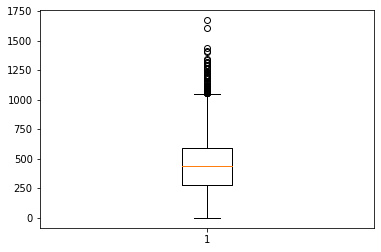

In [60]:
plt.boxplot(common_data['calls_duration'])

Для оценки распределения времени звонков я построил boxplot. На нём я виже небольшое количество выбросов примерно около 1400 минут, я не буду использовать эти значения при расчёте среднего.

In [61]:
common_data.query('calls_duration >= 1400')

,user_id,month,number_of_calls,calls_duration,traffic,number_of_messages,tariff,city,monthly_fee,calls_revenue,int_revenue,msg_revenue,total_revenue
1237,1196,2018-06-01,149.0,1410.0,22677.0,153.0,ultra,Воронеж,1950,0.0,0.0,0.0,1950.0
1359,1216,2018-12-01,162.0,1435.0,20095.0,64.0,smart,Волгоград,550,2805.0,924.8,42.0,4321.8
2353,1377,2018-03-01,165.0,1609.0,3063.0,20.0,ultra,Брянск,1950,0.0,0.0,0.0,1950.0
2360,1377,2018-10-01,148.0,1401.0,4887.0,10.0,ultra,Брянск,1950,0.0,0.0,0.0,1950.0
2966,1467,2018-12-01,190.0,1673.0,9768.0,39.0,ultra,Киров,1950,0.0,0.0,0.0,1950.0


In [62]:
tariff_stat['calls_mean'] = common_data.query('calls_duration <= 1400').groupby('tariff')['calls_duration'].mean()
tariff_stat['calls_median'] = common_data.groupby('tariff')['calls_duration'].median()
tariff_stat['calls_variance'] = common_data.groupby('tariff')['calls_duration'].apply(np.var, ddof=1)
tariff_stat['calls_deviation'] = tariff_stat['calls_variance'].apply(math.sqrt)

В отдельную таблицу я соберу статистики для тарифов, среднее значение я посчитаю без учёта выбросов (отброшу месяца длительностью звонков выше 1400 минут)

In [63]:
tariff_stat[['calls_mean', 'calls_median', 'calls_variance', 'calls_deviation']]

,calls_mean,calls_median,calls_variance,calls_deviation
tariff_name,,,,
smart,417.478456,422.0,36219.315784,190.313730
ultra,522.559633,518.0,100873.633397,317.606098


### Интернет

{'whiskers': [<matplotlib.lines.Line2D at 0x7f688c547090>,
 'caps': [<matplotlib.lines.Line2D at 0x7f688c54b7d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f688c547050>],
 'medians': [<matplotlib.lines.Line2D at 0x7f688c547d50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f688c552750>],
 'means': []}

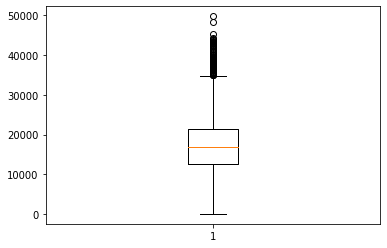

In [64]:
plt.boxplot(common_data['traffic'])

In [65]:
common_data.query('traffic >= 44000')

,user_id,month,number_of_calls,calls_duration,traffic,number_of_messages,tariff,city,monthly_fee,calls_revenue,int_revenue,msg_revenue,total_revenue
782,1124,2018-10-01,130.0,1225.0,49789.0,121.0,ultra,Махачкала,1950,0.0,2793.31,0.0,4743.31
1498,1240,2018-08-01,49.0,457.0,48395.0,0.0,ultra,Воронеж,1950,0.0,2589.11,0.0,4539.11
1596,1255,2018-07-01,29.0,263.0,45222.0,0.0,ultra,Саранск,1950,0.0,2124.32,0.0,4074.32
1880,1300,2018-11-01,74.0,658.0,44341.0,170.0,ultra,Москва,1950,0.0,1995.26,0.0,3945.26


На графике мы видим как распределено использование интернета в месяц по пользователям. Несколько отдельных результатов выше 44000 мб в месяц я принимаю за выбросы и не буду учитывать при расчёте среднего.

In [66]:
tariff_stat['internet_mean'] = common_data.query('traffic <= 44000').groupby('tariff')['traffic'].mean()
tariff_stat['internet_median'] = common_data.groupby('tariff')['traffic'].median()
tariff_stat['internet_variance'] = common_data.groupby('tariff')['traffic'].apply(np.var, ddof=1)
tariff_stat['internet_deviation'] = tariff_stat['internet_variance'].apply(math.sqrt)

In [67]:
tariff_stat[['internet_mean', 'internet_median', 'internet_variance',
       'internet_deviation']]

,internet_mean,internet_median,internet_variance,internet_deviation
tariff_name,,,,
smart,16229.188425,16531.0,3.454591e+07,5877.576978
ultra,19374.975535,19324.0,1.019356e+08,10096.317202


Посмотрим как распределено использование интернета в месяц по всем пользователям и по пользователям конкретных тарифов. Для удобства я добавлю значение предоставляемого тарифом трафика. 

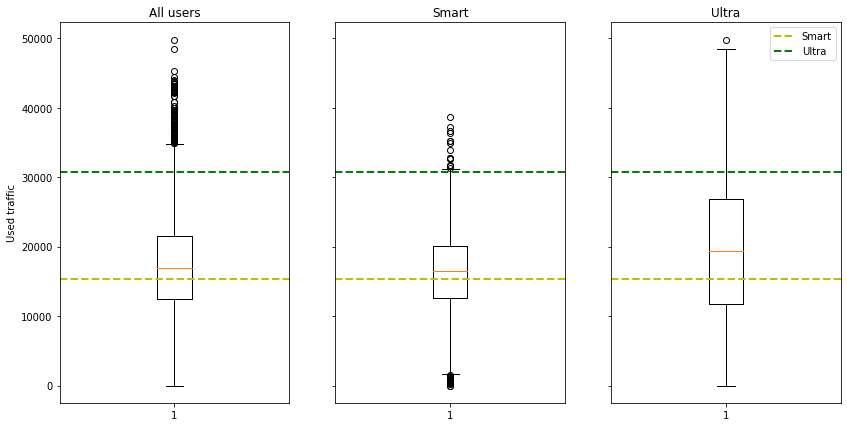

In [68]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(14,7))
ax1.boxplot(common_data['traffic'])
ax2.boxplot(common_data.query('tariff == "smart"')['traffic'])
ax3.boxplot(common_data.query('tariff == "ultra"')['traffic'])


ax1.title.set_text('All users')
ax2.title.set_text('Smart')
ax3.title.set_text('Ultra')

ax1.set_ylabel('Used traffic')
#ax1.set_yticks([0,500,2000,3000,6000,8000,10000,12000])
#ax1.set_yticklabels([0, 'Smart', 2000, 'Ultra',3000,6000,8000,10000,12000])

for axe in f.axes:
    axe.axhline(y=15360,
                linewidth=2, 
                color='y', 
                linestyle='--',
                label='Smart')
    axe.axhline(y=30720,
                linewidth=2, 
                color='g', 
                linestyle='--',
                label='Ultra')

plt.legend()

plt.show()

Посмотрим аналогичное распределение на гистограмме. Дополнительно я добавлю на диаграмму среднее значение и медиану

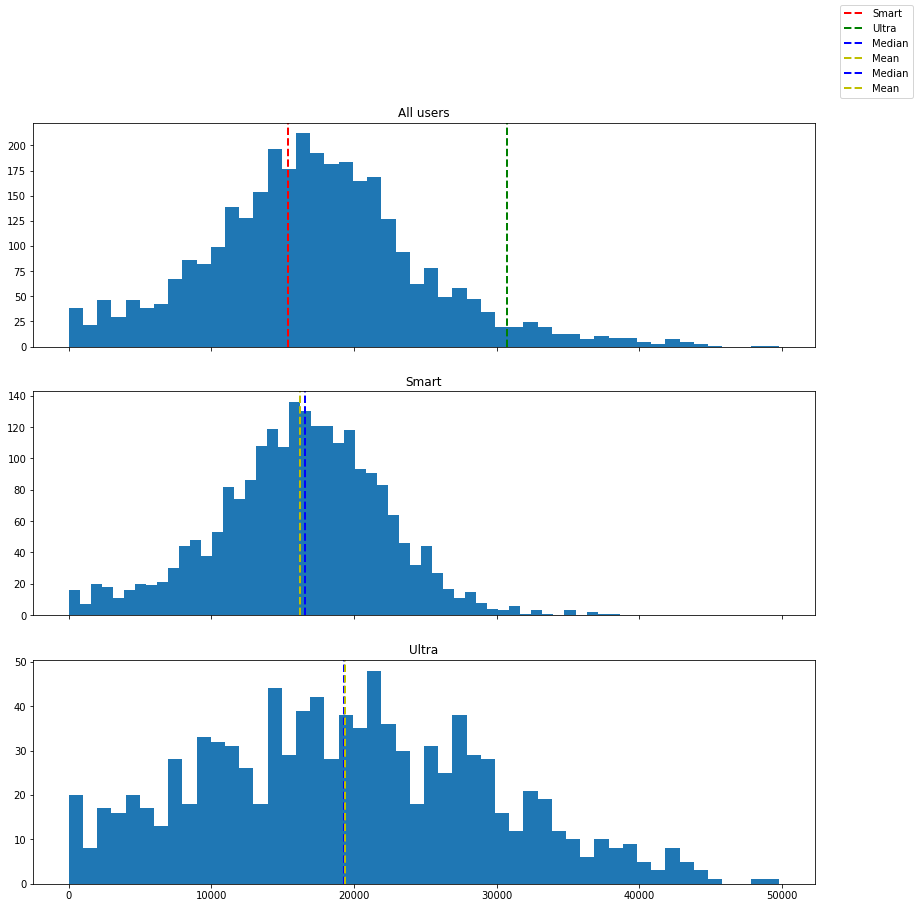

In [69]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14,14))
ax1.hist(common_data['traffic'], bins=50)
ax2.hist(common_data.query('tariff == "smart"')['traffic'], bins=50)
ax3.hist(common_data.query('tariff == "ultra"')['traffic'], bins=50)

ax1.title.set_text('All users')
ax2.title.set_text('Smart')
ax3.title.set_text('Ultra')

ax3.axvline(x=tariff_stat['internet_median']['ultra'], 
            linewidth=2, 
            color='b', 
            linestyle='--',
            label='Median')
ax2.axvline(x=tariff_stat['internet_median']['smart'], 
            linewidth=2, 
            color='b', 
            linestyle='--',
            label='Median')
ax3.axvline(x=tariff_stat['internet_mean']['ultra'], 
            linewidth=2, 
            color='y', 
            linestyle='--',
            label='Mean')
ax2.axvline(x=tariff_stat['internet_mean']['smart'], 
            linewidth=2, 
            color='y', 
            linestyle='--',
            label='Mean')

ax1.axvline(x=15360, 
            linewidth=2, 
            color='r', 
            linestyle='--',
            label='Smart')
ax1.axvline(x=30720, 
            linewidth=2, 
            color='g', 
            linestyle='--',
            label='Ultra')

f.legend()
plt.show()

Исходя из графиков выше мы можем увидеть, что использование интернета не сильно отличается среди пользователей двух тарифов. Средние и медиана не сильно отстоят как друг от друга, так и аналогичных значений для другого тарифа. Для тарифа Ультра выше стандартное отклонение, что также иллюстрирует график расположен он более широко. 
Тариф Смарт закрывает потребление примерно половины своих пользователей, а Ультра примерно для 80% пользователей.
В обоих случаях мы наблюдаем нормальное распределеине.

### Сообщения

Посмотрим на распределение количества отправляемых смс пользователями в месяц.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6881c3f0d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f688bfff7d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6881c3f050>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6881a5e4d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6881e16390>],
 'means': []}

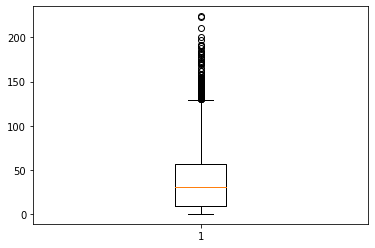

In [107]:
plt.boxplot(common_data['number_of_messages'])

На графике мы видим, что примерно половина всех пользователей отправляет не более 200 сообщений в месяц и почти все умещаются в 800, хвост достаточно сильно растянут вверх. Верхние значения я не буду использовать для расчёта среднего.

In [108]:
common_data.query('number_of_messages >= 200')

,user_id,month,number_of_calls,calls_duration,traffic,number_of_messages,tariff,city,monthly_fee,calls_revenue,int_revenue,msg_revenue,total_revenue,city_cat,month_num
183,1028,2018-10-01,107.0,954.0,22519.0,223.0,ultra,Тверь,1950,0.0,0.0,0.0,1950.0,0,10
1028,1165,2018-12-01,33.0,278.0,31972.0,224.0,ultra,Самара,1950,0.0,183.4,0.0,2133.4,0,12
3186,1231,2018-06-01,0.0,0.0,27850.0,201.0,ultra,Чебоксары,1950,0.0,0.0,0.0,1950.0,0,6
3187,1231,2018-07-01,0.0,0.0,27718.0,211.0,ultra,Чебоксары,1950,0.0,0.0,0.0,1950.0,0,7


Добавлю значения среднего, медианы, дисперсии и распределения по количеству смс в месяц для каждого тарифа в таблицу

In [109]:
tariff_stat['sms_mean'] = common_data.query('number_of_messages <= 200').groupby('tariff')['number_of_messages'].mean()
tariff_stat['sms_median'] = common_data.groupby('tariff')['number_of_messages'].median()
tariff_stat['sms_variance'] = common_data.groupby('tariff')['number_of_messages'].apply(np.var, ddof=1)
tariff_stat['sms_deviation'] = tariff_stat['sms_variance'].apply(math.sqrt)
tariff_stat[['sms_mean', 'sms_median', 'sms_variance','sms_deviation']]

,sms_mean,sms_median,sms_variance,sms_deviation
tariff_name,,,,
smart,33.384029,28.0,796.812958,28.227876
ultra,48.689093,38.0,2285.266143,47.804457


Посмотрим как распределяется количество отправляемых сообщений для пользователей разных тарифов. Для этого я построю boxplot, а также отмечу на нём количество сообщений предоставляемых тарифом.

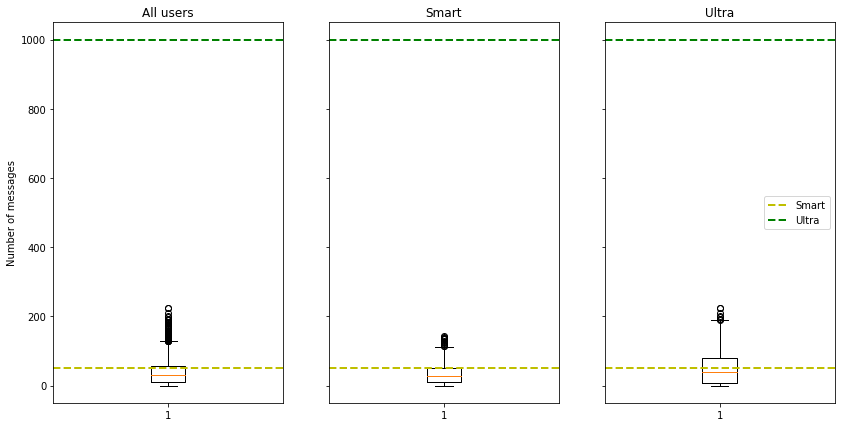

In [73]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(14,7))
ax1.boxplot(common_data['number_of_messages'])
ax2.boxplot(common_data.query('tariff == "smart"')['number_of_messages'])
ax3.boxplot(common_data.query('tariff == "ultra"')['number_of_messages'])


ax1.title.set_text('All users')
ax2.title.set_text('Smart')
ax3.title.set_text('Ultra')

ax1.set_ylabel('Number of messages')
#ax1.set_yticks([0,500,2000,3000,6000,8000,10000,12000])
#ax1.set_yticklabels([0, 'Smart', 2000, 'Ultra',3000,6000,8000,10000,12000])

for axe in f.axes:
    axe.axhline(y=50,
                linewidth=2, 
                color='y', 
                linestyle='--',
                label='Smart')
    axe.axhline(y=1000,
                linewidth=2, 
                color='g', 
                linestyle='--',
                label='Ultra')

plt.legend()

plt.show()

На графиках видно, что примерно 75% вообще всех пользователей уместились бы в ограничения тарифа Смарт. Также мы не видим значений выше 250. В общем видно, что пользователи тарифа Ультра отправляют больше сообщений, но не значительно.

Пострю по этим же данным гистограмму, чтобы увидеть форму распределения. Также добавлю на график среднее значение и медиану для каждого тарифа.

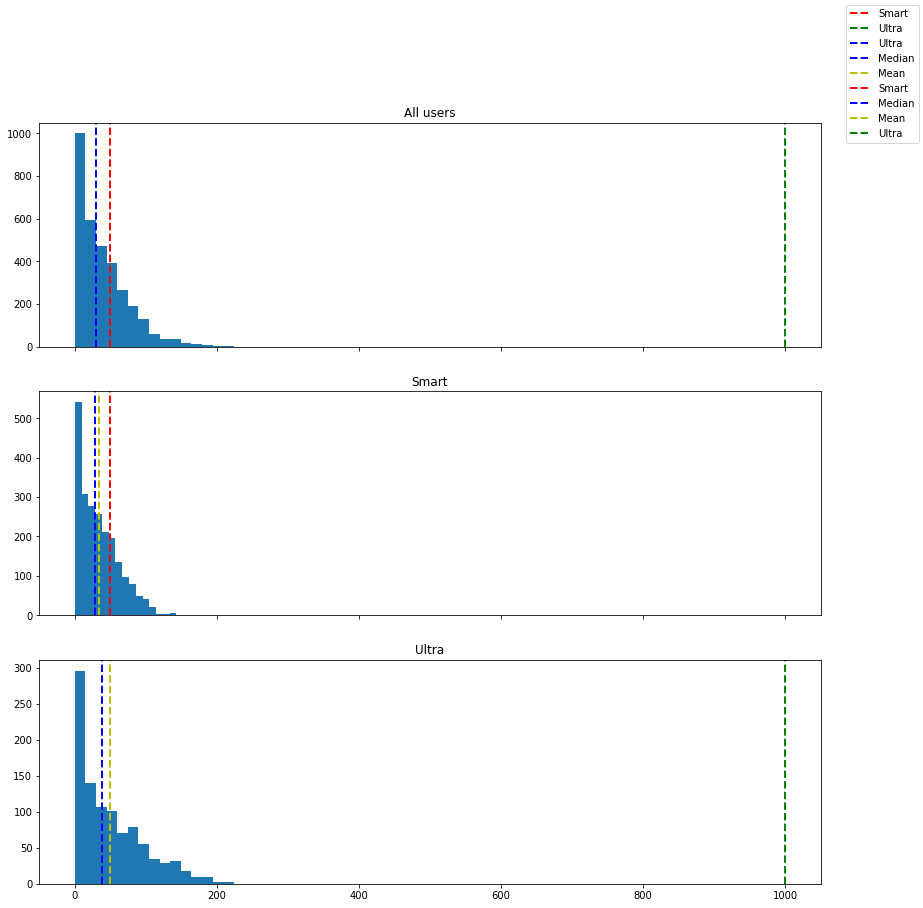

In [74]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14,14))
ax1.hist(common_data['number_of_messages'], bins=15)
ax2.hist(common_data.query('tariff == "smart"')['number_of_messages'], bins=15)
ax3.hist(common_data.query('tariff == "ultra"')['number_of_messages'], bins=15)

ax1.title.set_text('All users')
ax2.title.set_text('Smart')
ax3.title.set_text('Ultra')

ax3.axvline(x=tariff_stat['sms_median']['ultra'], 
            linewidth=2, 
            color='b', 
            linestyle='--',
            label='Median')
ax2.axvline(x=tariff_stat['sms_median']['smart'], 
            linewidth=2, 
            color='b', 
            linestyle='--',
            label='Median')
ax3.axvline(x=tariff_stat['sms_mean']['ultra'], 
            linewidth=2, 
            color='y', 
            linestyle='--',
            label='Mean')
ax2.axvline(x=tariff_stat['sms_mean']['smart'], 
            linewidth=2, 
            color='y', 
            linestyle='--',
            label='Mean')

ax1.axvline(x=50, 
            linewidth=2, 
            color='r', 
            linestyle='--',
            label='Smart')
ax2.axvline(x=50, 
            linewidth=2, 
            color='r', 
            linestyle='--',
            label='Smart')
ax1.axvline(x=1000, 
            linewidth=2, 
            color='g', 
            linestyle='--',
            label='Ultra')
ax3.axvline(x=1000, 
            linewidth=2, 
            color='g', 
            linestyle='--',
            label='Ultra')
ax1.axvline(x=common_data['number_of_messages'].median(), 
            linewidth=2, 
            color='b', 
            linestyle='--',
            label='Ultra')
f.legend()
plt.show()

На трёх графиках выше мы видим, что пользователи чаще всего используют сообщения минимально (об этом свидетельствует высокий столбец в самом начале слева). Распределение напоминает Пуассоновское и выглядит очень похоже для обоих тарифов.

Исходя из графиков наглядно видно, что пользователи не используют смс активно и ещё лучше видно, что 1000 штук в тарифе вообще никому не нужны. Почти все пользователи отправляют меньше 200 сообщений в месяц, половина всех пользователей отправляет 50 и меньше.
Доплачивают за смс сейчас около 25% пользователей. Зная будущее развития этой ситуации - эта цифра будет снижаться.

### Вывод

Соберём посчитанные данные вместе и оценим использование услуг пользователями двух тарифов.

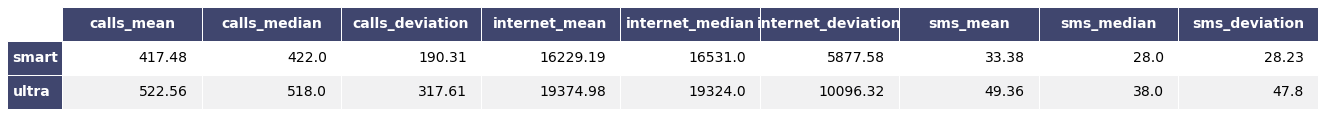

In [75]:
def render_mpl_table(data, col_width=5.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, rowLabels=data.index, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

ax = render_mpl_table(tariff_stat[['calls_mean', 'calls_median', 'calls_deviation',
       'internet_mean', 'internet_median', 'internet_deviation', 'sms_mean', 'sms_median',
       'sms_deviation']].round(2), header_columns=0, col_width=2.5)

Из таблицы мы видим, что пользователи тарифа Ультра в среднем больше используют услуги. При этом мы видим, что стандартное отклонение на этом тарифе тоже выше и вероятно можно найти пользователей, которые используют услуги не так активно и могут перейти на тариф ниже.

Теперь посмотрим на средние показатели по выручке от пользователя каждого конкретного тарифа.

In [76]:
user_stats

,calls_duration,calls_revenue,int_revenue,msg_revenue,number_of_calls,number_of_messages,total_revenue,traffic,age,churn_date,...,reg_month,month_active,monthly_fee,calls_duration_avg,calls_revenue_avg,traffic_avg,int_revenue_avg,number_of_messages_avg,msg_revenue_avg,mean_revenue
user_id,,,,,,,,,,,,,,,,,,,,,
1000,2566.0,0.0,0.00,0.0,293.0,496.0,15600.00,107492.0,52,NaT,...,2018-05-01,8,1950,320.750000,0.0,13436.500000,0.000000,62.0,0.00,1950.000000
1001,844.0,0.0,603.91,0.0,92.0,0.0,1703.91,32505.0,41,NaT,...,2018-11-01,2,550,422.000000,0.0,16252.500000,301.955000,0.0,0.00,851.955000
1002,1517.0,0.0,2852.93,0.0,173.0,70.0,6702.93,116183.0,59,NaT,...,2018-06-01,7,550,216.714286,0.0,16597.571429,407.561429,10.0,0.00,957.561429
1003,3822.0,0.0,0.00,0.0,428.0,380.0,9750.00,57329.0,23,NaT,...,2018-08-01,5,1950,764.400000,0.0,11465.800000,0.000000,76.0,0.00,1950.000000
1004,987.0,0.0,0.00,0.0,139.0,1192.0,15600.00,149172.0,68,NaT,...,2018-05-01,8,1950,123.375000,0.0,18646.500000,0.000000,149.0,0.00,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,3920.0,0.0,1558.16,0.0,466.0,340.0,11308.16,127536.0,65,NaT,...,2018-08-01,5,1950,784.000000,0.0,25507.200000,311.632000,68.0,0.00,2261.632000
1496,5984.0,1548.0,19246.68,3.0,667.0,468.0,27397.68,271269.0,36,NaT,...,2018-01-01,12,550,498.666667,129.0,22605.750000,1603.890000,39.0,0.25,2283.140000
1497,1406.0,135.0,894.53,0.0,156.0,51.0,2679.53,45626.0,32,NaT,...,2018-10-01,3,550,468.666667,45.0,15208.666667,298.176667,17.0,0.00,893.176667


In [111]:
common_data

,user_id,month,number_of_calls,calls_duration,traffic,number_of_messages,tariff,city,monthly_fee,calls_revenue,int_revenue,msg_revenue,total_revenue,city_cat,month_num
0,1000,2018-05-01,17.0,159.0,2256.0,22.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00,0,5
1,1000,2018-06-01,28.0,172.0,23257.0,60.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00,0,6
2,1000,2018-07-01,41.0,340.0,14016.0,75.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00,0,7
3,1000,2018-08-01,42.0,408.0,14070.0,81.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00,0,8
4,1000,2018-09-01,46.0,466.0,14581.0,57.0,ultra,Краснодар,1950,0.0,0.00,0.0,1950.00,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,2018-08-01,0.0,0.0,11066.0,17.0,smart,Санкт-Петербург,550,0.0,0.00,0.0,550.00,0,8
3210,1489,2018-09-01,0.0,0.0,17232.0,32.0,smart,Санкт-Петербург,550,0.0,365.62,0.0,915.62,0,9
3211,1489,2018-10-01,0.0,0.0,19588.0,21.0,smart,Санкт-Петербург,550,0.0,825.78,0.0,1375.78,0,10
3212,1489,2018-11-01,0.0,0.0,17516.0,20.0,smart,Санкт-Петербург,550,0.0,421.09,0.0,971.09,0,11


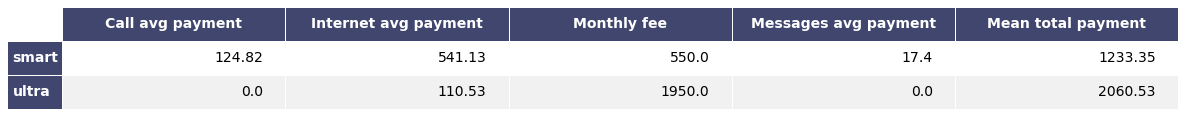

In [116]:
revenue_stats = common_data.pivot_table(index='tariff', values=['calls_revenue','msg_revenue','int_revenue', 'monthly_fee', 'total_revenue'], aggfunc=['mean']).round(2)
revenue_stats.columns = ['Call avg payment', 'Internet avg payment', 'Monthly fee', 'Messages avg payment', 'Mean total payment' ]

ax = render_mpl_table(revenue_stats, header_columns=0, col_width=4.0)

Исходя из таблицы мы видим, что хоть пользователи тарифа доплачивают только за интернет и в среднем совсем небольшую сумму, сумма выручки по ним выше.

Изучив собранные данные можно сделать следующие выводы:
 - поведение абонентов разных тарифов отличается: пользователи тарифа Смарт в среднем используют меньше сообщений, интернета и звонков, чем пользователи тарифа Ультра. Этим можно попробовать объяснить их выбор, если они интуитивно понимают, что они общаются ниже среднего и выбирают меньший из двух тарифов.
 - абоненты тарифа Смарт платят на примерно 40% меньше, абонентов Ультра. При этом доплаты сверх тарифа составляют для них ещё 130% стоимости тарифа, но это всё равно ниже стоимости только абонентской платы на тарифе Ультра.
 - услуга, за которую доплачивают больше и чаще всего это интернет - эта доп стоимость составляет более половины расходов всех пользователей тарифа Смарт. При этом абоненты тарифа Ультра вообще не доплачивают за другие услуги (и даже не близко к тому, чтобы потратить предложенный объём услуг)

 
Рекомендации: для оценки прибыльности тарифов необходимо иметь данные по себестоимости оказываемых услуг и рассчитать прибыль, которую приносят абоненты разных тарифов. Исходя из даным по выручке пользователи Ультра платят на 40 больше, а тратят примерно на 20% больше - исходя из этого предположим, что они и приносят больше прибыли. На эту информацию можно опираться для корректировки бюджета - тариф Ультра приносит больше денег, а также имеет больше преимуществ для пользователей (можно не бояться писать смс, минимум доплат), вероятно и аудитория для рекламы будет более узкая, что позволит оптимизировать бюджет.

## Статистический анализ и проверка гипотез

### Гипотеза 1

Гипотеза номер 1, которую нужно проверить, звучит как: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
Нулевая гипотеза будет звучать как: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается, т.е. они равны.
Альтернативная: средняя выручка пользователей тарифов «Смарт» и "Ультра" отличаются.
Т.к. пользователи являются абонентами и используют услуги разное количество месяцев - мы возьмём для анализа среднюю выручку за активный месяц для пользователя.

In [78]:
alpha = 0.05

results = st.ttest_ind(common_data.query('tariff == "ultra"')['total_revenue'], 
                       common_data.query('tariff == "smart"')['total_revenue'])
#equal_var = False , т.к. дисперсия в выборках по тарифам сильно отличается
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    
results.statistic

p-значение: 1.1725472632484435e-190
Отвергаем нулевую гипотезу


31.56020763371424

По результатам t-теста вероятность получить такую разницу для равных выборок невероятно мала. Значит мы отвергаем нулевую гипотезу и предположение о том, что среднее значение выручки для двух тарифов не отличается. Исходя из результатов исследовательского анализа можем дополнить этот вывод тем, средняя выручка пользователей Ультра выше.

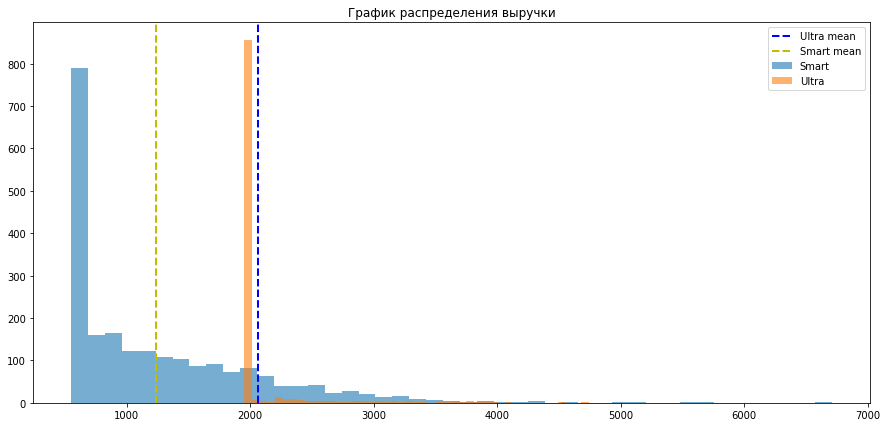

In [79]:
plt.figure(figsize=(15,7))
plt.hist(common_data.query('tariff == "smart"')['total_revenue'], alpha=0.6, label='Smart', bins=45)
plt.hist(common_data.query('tariff == "ultra"')['total_revenue'], alpha=0.6, label='Ultra', bins=45)
plt.axvline(x=common_data.query('tariff == "ultra"')['total_revenue'].mean(), 
            linewidth=2, 
            color='b', 
            linestyle='--',
            label='Ultra mean')
plt.axvline(x=common_data.query('tariff == "smart"')['total_revenue'].mean(), 
            linewidth=2, 
            color='y', 
            linestyle='--',
            label='Smart mean')


plt.legend()

plt.title('График распределения выручки')
plt.show()

### Гипотеза 2

Гипотеза номер 2, которую нужно проверить, звучит как:	средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
Нулевая гипотеза: средняя выручка пользователей из Москвы не отличается от пользователей из других регионов.
Альтернативная: отличается.

In [80]:
alpha = 0.05

results = st.ttest_ind(common_data.query('city == "Москва"')['total_revenue'], common_data.query('city != "Москва"')['total_revenue'])
#equal_var = False , т.к. дисперсия в выборках по тарифам сильно отличается
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    
results.statistic

p-значение: 0.4744327296711197
Не получилось отвергнуть нулевую гипотезу


0.7153695313317112

In [81]:
common_data.query('city == "Москва"')['total_revenue'].mean()

1507.2766939443536

In [82]:
common_data.query('city != "Москва"')['total_revenue'].mean()

1482.0637072608529

С вероятностью в 47% разница между средним в выборках могла получиться случайно и мы не можем утверждать, что в разных регионах пользователи разных тарифов приносят отличающуюся выручку. 

Доп комментарии:
 - нулевая гипотеза формировалась исходя из условия равенства средних двух выборок, т.е. я предположил, что на самом деле средние значения равны. Соответственно альтернативная гипотеза - это обратное равенство
 - для проверки я формулировал гипотезы о равенстве средних двух генеральных совокупностей

## Вывод

На основе полученных данных мы сравнили данные по выборе пользователей двух тарифов и соотнесли их между собой. Я сравнил данные по количеству разговоров, отправленных сообщений и потраченных мб, а также стоимости этих услуг и абонентской платы. В таблице ниже можно наглядно увидеть разницу между количеством используемых услуг. Если кратко - пользователи тарифа Ультра используют их больше, но не значительно.

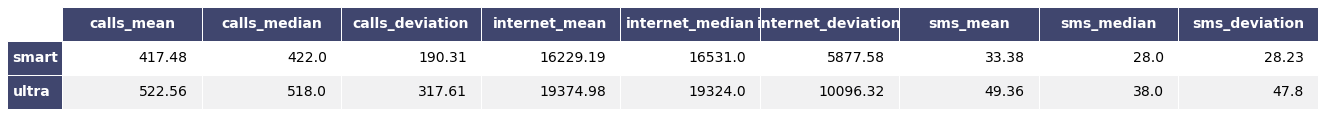

In [83]:
ax= render_mpl_table(tariff_stat[['calls_mean', 'calls_median', 'calls_deviation',
       'internet_mean', 'internet_median', 'internet_deviation', 'sms_mean', 'sms_median',
       'sms_deviation']].round(2), header_columns=0, col_width=2.5)

Если сравнить выручку за каждый тип услуг и в среднем по тарифу - пользователи тарифа Ультра платят больше, в первую очередь за счёт больше абонентской платы и редко тратят включённый объём услуг.

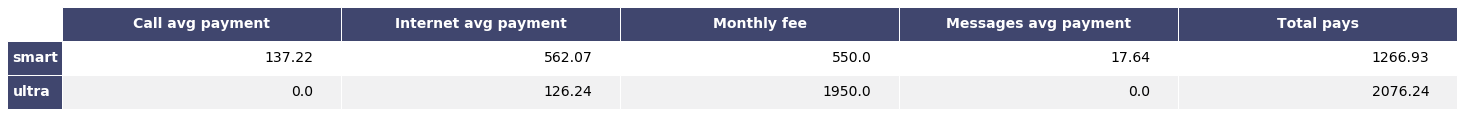

In [84]:
ax = render_mpl_table(revenue_stats, header_columns=0, col_width=5.0)

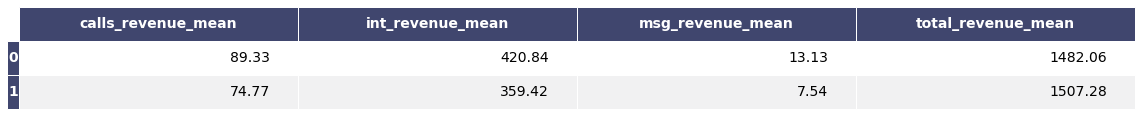

In [85]:
common_data['city_cat'] = (common_data['city'] == 'Москва')*1
revenue_stats2 = common_data.pivot_table(index='city_cat', values=['calls_revenue','msg_revenue','int_revenue', 'total_revenue'], aggfunc=['mean']).round(2)
revenue_stats2.columns = ['calls_revenue_mean', 'int_revenue_mean', 'msg_revenue_mean','total_revenue_mean' ]
ax = render_mpl_table(revenue_stats2, header_columns=0, col_width=5.0)

Там же мы проверили гипотезу о том, что пользователи разных тарифов в среднем приносят одинаковую прибыль и отбросили её.
А гипотезу о том, что в среднем пользователи из Москвы и других городов отбросить не смогли (на цифрах это тоже видно, пользователи из Москвы тратят в среднем на 4% меньше).

Рекомендация аналитика - скорректировать рекламный бюджет в пользу тарифа Ультра. Пользователи на этом тарифе в среднем платят больше денег (только абонентская плата выше всех расходов пользователей тарифа Смарт). Кроме того ряд результатов настоящего исследования можно использовать для рекламных кампаний, как преимущества (практически полное отсутствие доплат, большое количество заложенных в пакет услуг, предсказуемость суммы ежемесячных платежей). Важно учитывать также потенциальную аудиторию обоих тарифов - более дорогой тариф сможет позволить себе меньшее количество пользователей, соответственно может получиться, что суммарная выручка будет выше для тарифа Смарт. Важно при определении рекламного бюджета учитывать не только среднюю выручку по выборке пользователей, но также учитывать доходность по каждому пользователю, текущее соотношение по размеру базы пользователей обоих тарифов, а также тренды рынка. Результаты текущего исследования нельзя назвать исчерпывающими для уверенного принятия решения, но можно использовать вместе с глобальным данными компании для взвешенной оценки.